Started...
1488  Malignant found
MY_ERROR: key not found:
 1.2.840.113681.2229460924.948.3513224549.627
1487 DICOM images extracted
(3062, 2394)
(2294, 1914)
(2294, 1914)
shape =  (131, 160)


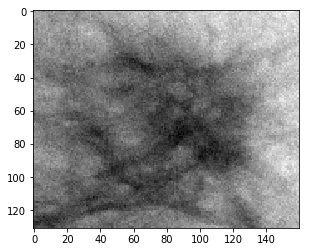

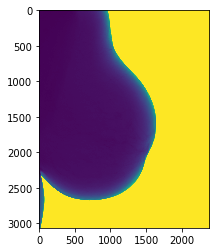

In [43]:
import glob
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt

print('Started...')

# Load dicom files into np array

malignant = np.array([])
dicomImg = {'malignant':np.array([]), 'normal':np.array([])}
count = 0
fMal = glob.glob('/vol/vssp/mammo2/will/data/dcm/malignant/*')
print(len(fMal), ' Malignant found')
for f in fMal:
    dicomImg['malignant'] = np.append(dicomImg['malignant'], pydicom.dcmread(f))
    count += 1
#     print(count, '/', len(fMal))
# fNorm = glob.glob('/vol/vssp/mammo2/will/data/dcm/normal/*')
# print(len(fNorm), ' Normal found')
# count = 0
# for f in fNorm:
#     dicomImg['normal'] = np.append(dicomImg['normal'], pydicom.dcmread(f))
#     count += 1
#     print(count, '/', len(fNorm))

# Import xls file
xls = pd.ExcelFile('/vol/vssp/mammo2/will/data/batch_50_IMAGE.xls')
sheet = xls.parse(1)


# Create a dict where the key is the image name
# Each key has the image, and coords
img = {}
for i in range(len(fMal)):
    key = os.path.basename(fMal[i])[:-4]
    # Find row in the xml file that holds the img info
    try:
        indx = [_==key for _ in sheet['ReferencedSOPInstanceUID']].index(True)
        img.update({key:{}})
        img[key].update({'img': dicomImg['malignant'][i].pixel_array})
        img[key].update({'x': [sheet['X1'][indx], sheet['X2'][indx]]})
        img[key].update({'y': [sheet['Y1'][indx], sheet['Y2'][indx]]})
    except ValueError:
        print('MY_ERROR: key not found:\n', key)
        
print(len(img), 'DICOM images extracted')
# print(img)
print(img['1.2.840.113619.2.227.2079195738.2772140709111020.85']['img'].shape)
print(img['1.2.840.113619.2.227.2079243250246.1888121022134218.77']['img'].shape)
print(img['1.2.840.113619.2.227.2079243250246.1888121022134534.85']['img'].shape)
# Crop the images to ROI
for key in img:
    tmp = img[key]['img']
    x = img[key]['x']
    y = img[key]['y']
    #x is width, y is height
    #in numpy array, y,x
    img[key].update({'crop':tmp[y[0]:y[1], x[0]:x[1]]}) 
    
img_calc = img['1.2.840.113619.2.227.2079195738.2772140709111020.85']['crop'] / 16383

#img_calc = np.reshape(img_calc, (img_calc.shape[0], img_calc.shape[1], 1))
print('shape = ', img_calc.shape)
plt.imshow(img_calc, cmap='gray')
plt.show()
plt.imshow(img['1.2.840.113619.2.227.2079195738.2772140709111020.85']['img']/16383)
plt.show()

# Crop images to ROI






In [37]:
print('hello world')

hello world


In [32]:
import pydicom
from pydicom.data import get_testdata_files
x = np.array([])
filename = get_testdata_files("MR_small.dcm")[0]
ds = pydicom.dcmread(filename)
print(ds.pixel_array.shape)


(64, 64)
